# QHack Open Project  
## Team Qumulus Nimbus  
Team members: Praveen J and my cats. PS, I'm not a cat. 
## Project title: Feeding many trolls

### Project abstract:  
We provide a pennylane implementation of single qubit universal quantum classifier similar to that presented in [1] and [2]. We then provide an efficient method to parallely process classical data using a qram setup for the universal single qubit classifier.  
We then attempt to address quantum classifiers by data reuploading for **Quantum Data** for experiments when we have copies of the quantum state and show it's performance, which we believe has not been done before.  

We use the universal quantum classifier method and measurement strategies described in [1] to demonstrate a method of quantum music learning and generation by recasting the classifier into a markov chain like setup. We also use the qram structure we developed to combine and generate music. 

### Introduction:  


Since our goal as a qhack project is to showcase our new ideas of encoding and music processing methods, we restrict all our methods to binary classification, but with some extra short steps, all can be extended to mulitple class classification by methods similar to that outlined in [1], which we do later on for the twelve note music scale similar to the tetrehedron shown in [1].

In [17]:
import pennylane as qml
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

In [9]:
#generating a circularly symmetric data set
dataset_size = 500
X_train = np.random.uniform(low=-1, high=1, size=(dataset_size, 2))
Y_train = np.ones(dataset_size)
for i in range(len(X_train)):
    dist = np.sqrt(X_train[i][0]**2 + X_train[i][1]**2)
    if dist > 0.8:
        Y_train[i] = -1
print(Y_train[:20])
print(X_train[:20])

[ 1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1. -1.]
[[ 0.11546391  0.5794413 ]
 [ 0.17668031 -0.42143883]
 [ 0.90546895  0.88519638]
 [-0.84857842 -0.63074686]
 [ 0.14125159 -0.96266139]
 [ 0.44775076 -0.45366258]
 [ 0.22530292 -0.77399524]
 [-0.75706397  0.51428002]
 [-0.34374666 -0.26271382]
 [ 0.24684088 -0.60517776]
 [-0.54503503 -0.34490355]
 [ 0.94067546 -0.45269719]
 [-0.93532978 -0.67094935]
 [-0.45046512  0.62465724]
 [ 0.00975317 -0.93340515]
 [-0.07789964 -0.98637493]
 [-0.53758496  0.52797987]
 [-0.41498539  0.19843941]
 [ 0.72943703  0.88673288]
 [ 0.26875761  0.79095308]]


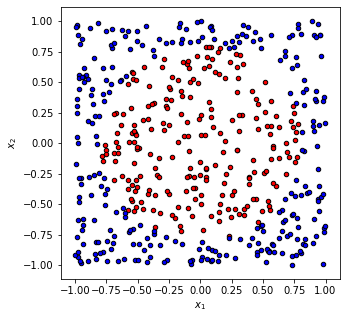

In [20]:
#plotting generated data
def plot_data(x, y, nclass, fig=None, ax=None): 
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
     
    # colors and labels
    col = ["red","blue"]
    lab = [1,-1]
    
    for i in range(nclass):
        ax.scatter(x[y == lab[i], 0], x[y == lab[i], 1], c=col[i], s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

plot_data(X_train, Y_train, 2)

In [21]:
#simple re-implementation of classical data uploading

#initializations
num_qubit = 1
num_layers = 10
weights = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_layers, 7)) #assuming 2D data input
batch_size = 5

dev = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.0002)

def apply_data_layer(params, wires, data):
    qml.Rot(params[0, 0]*data[0] + params[0, 1], 
            params[1, 0]*data[1] + params[1, 1], 
            0, 
            wires=wires)

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev)
def apply_layers(params, wires, data):
    #reshaping parameters for ease
    data_params = params[:,:4].reshape((len(params), 2, 2))
    mixing_params = params[:,4:].reshape((len(params), 3))
    for i in range(num_layers):
        apply_data_layer(data_params[i], wires=wires, data=data)
        apply_mixing_layer(mixing_params[i], wires=wires)
    return qml.expval(qml.PauliZ(wires))

def square_loss(labels, predictions): #just defining it, but not using it
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def fidelity_loss(labels, predictions): #fidelity loss, unweighted
    loss = 0.0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - l*p)**2/2
    loss = loss / len(labels)
    return loss

def cost(w, X, Y):
    predictions = [apply_layers(w, wires=0, data = x) for x in X]
    return square_loss(Y, predictions)

n = int(len(X_train)/batch_size)
we = weights
for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    we = opt.step(lambda w: cost(w, X_train_batch, Y_train_batch), we)
    print('Cost at step '+ str(a) + ': ' + str(cost(we, X_train_batch, Y_train_batch)))

Cost at step 0: 1.4415418702587601
Cost at step 1: 1.1370070480138568
Cost at step 2: 1.8809053694423312
Cost at step 3: 1.440147193662442
Cost at step 4: 0.8110386037826169
Cost at step 5: 1.4928717816213883
Cost at step 6: 0.8287727557010276
Cost at step 7: 0.8787222150956915
Cost at step 8: 0.8618635560420659
Cost at step 9: 0.5369263535652207
Cost at step 10: 1.3079353813718886
Cost at step 11: 1.606076979856518
Cost at step 12: 2.609745599319006
Cost at step 13: 0.4141949042087288
Cost at step 14: 0.8845220584794473
Cost at step 15: 0.6748726963582506
Cost at step 16: 0.9268722205940897
Cost at step 17: 0.5455689776531993
Cost at step 18: 0.18562228020576382
Cost at step 19: 0.8935519042429483
Cost at step 20: 1.350986659894358
Cost at step 21: 0.4086038452550526
Cost at step 22: 0.06925691611807543
Cost at step 23: 1.610137387927632
Cost at step 24: 1.78989016844365
Cost at step 25: 0.7652183064991636
Cost at step 26: 0.7220467912434119
Cost at step 27: 1.164901999968886
Cost at 

### Data classification and re-uploading with a qram  
We use a simple amplitude encoding as described in [3] to encode 2 dimensional and 3 dimentional input data. We restrict ourselves to binary classification for simplicity.  

<img src="images/qram.png">

In each encoding step, we use controlled gates, controlled on the qram qubits. This allows us to parallely compute multiple training cases, while trading off circuit depth. Since we are using circuit fidelity as given in the equation above, we do something smart, we apply controlled gates again based on the targetted training classification \[0, 1\] and then we measure the output expectation value (perform a state tomography for fidelity). We apply a NOT gate if the label is -1 ($|1\rangle\langle1|$). On measuring expectation over Pauli Z basis, we get:
State post circuit:

\begin{align*}
    |\psi\rangle &= \frac{1}{\sqrt{N}} \sum_i |i\rangle|\psi_i\rangle \text{ where } \psi_i \text{ refers to state post circuit} \\
    x &= \frac{1}{N}(\sum_i \langle \psi_i | (|0\rangle\langle 0| - |1\rangle\langle 1|)|\psi_i \rangle)\\
    \text{Required fidelity } f &= \frac{1}{N}(\sum_i \langle \psi_i | (|0\rangle\langle 0|)|\psi_i \rangle)\\
    &= \frac{1}{2N}(\sum_i \langle \psi_i |(|0\rangle\langle 0| + |1\rangle\langle 1| + |0\rangle\langle 0| - |1\rangle\langle 1|)|\psi_i \rangle)\\
    &= \frac{1}{2}(1 + x)\\
    \text{Cost function: } L &= 1 - f = \frac{1}{2}(1 - x) \text{ where x is the measured value.}
\end{align*}



For a n qubit qram, we can process a batch size of $2^n$. Additionally we can proces batches of size $m \neq 2^k$ by not performing gate operations on those states and appropriately modifying fidelity in the end. For a batch size of m, qrammed over n qubits, $N = 2^n > m$:
$$\text{Cost function: } L = \frac{1}{2}(1-x)\times \frac{N}{m}$$

Additionally to optimise the circuit, we perform some preprocessing on the rotation angles to reduce some mulitple qubit controlled rotation gates into uncontrolled and lower order control rotation gates. For example, for a qram over states (batch size 4), if $a, b, c, d$ were the rotation angles for each of them, we have the following decomposition:

Now let's implement this for a batch size of 4 (2 qubit qram). Note that for ease of implementation, we have introduced a 4th qubit to act as an indicator for $|11\rangle$ qram state so as to avoid repeated Toffoli gates.

<img src="images/simplification.png">

In [23]:
#initialization
num_qubit = 4
layers = 10
X_train = [[0.5, 0.3, -0.4], [0.4, 0.2, 0.1], [0.4, 0.2, 0.2], [-0.5, 0.3, 0.6]]
Y_train = [-1, 1, 1, -1]
batch_size = 4 #qrammed!
weights = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_layers, 9)) #3D input

dev2 = qml.device("default.qubit", wires=num_qubit)
opt = qml.GradientDescentOptimizer(stepsize=0.2)

def apply_data_layer_qram(params, wires, data):
    a = []
    b = []
    c = []
    for i in range(len(data)):
        a.append(params[0, 0]*data[i][0] + params[0, 1])
        b.append(params[1, 0]*data[i][1] + params[1, 1])
        c.append(params[2, 0]*data[i][2] + params[2, 1])
    transform = lambda arr: [arr[0], arr[1] - arr[0], arr[2] - arr[0], arr[3] + arr[0] - arr[1] - arr[2]]
    a = transform(a)
    b = transform(b)
    c = transform(c)
    
    qml.RZ(a[0], wires=wires[0])
    qml.CRZ(a[1], wires=[wires[1], wires[0]])
    qml.CRZ(a[2], wires=[wires[2], wires[0]])
    qml.CRZ(a[3], wires=[wires[3], wires[0]])
    
    qml.RY(b[0], wires=wires[0])
    qml.CRY(b[1], wires=[wires[1], wires[0]])
    qml.CRY(b[2], wires=[wires[2], wires[0]])
    qml.CRY(b[3], wires=[wires[3], wires[0]])
    
    qml.RZ(c[0], wires=wires[0])
    qml.CRZ(c[1], wires=[wires[1], wires[0]])
    qml.CRZ(c[2], wires=[wires[2], wires[0]])
    qml.CRZ(c[3], wires=[wires[3], wires[0]])

def apply_mixing_layer(params, wires):
    qml.Rot(params[0], 
            params[1],
            params[2],
            wires=wires)

@qml.qnode(dev2)
def apply_layers_qram_train(params, wires, data, label):
    #qram initialization on wires 1, 2; wire 3 is used as an auxilary
    qml.Hadamard(wires=wires[1])
    qml.Hadamard(wires=wires[2])
    qml.Toffoli(wires=wires[1:])
    
    #reshaping parameters for ease
    data_params = params[:,:6].reshape((len(params), 3, 2))
    mixing_params = params[:,6:].reshape((len(params), 3))
    
    for i in range(num_layers):
        apply_data_layer_qram(data_params[i], wires=wires, data=data)
        apply_mixing_layer(mixing_params[i], wires=wires[0])
    
    #label encoding for batch fidelity
    if label[1] == -1:
        qml.CNOT(wires=[wires[1], wires[0]])
    if label[2] == -1:
        qml.CNOT(wires=[wires[2], wires[0]])
    if label[3] == -1:
        qml.CNOT(wires=[wires[3], wires[0]])
    if label[0] == -1:
        qml.PauliX(wires=wires[1])
        qml.PauliX(wires=wires[2])
        qml.Toffoli(wires=[wires[1], wires[2], wires[0]])
    return qml.expval(qml.PauliZ(wires[0]))

def cost_qram(w, X, Y):
    x = apply_layers_qram_train(w, wires=[0, 1, 2, 3], data = X, label = Y)
    return (1-x)/2

n = int(len(X_train)/batch_size)

for a in range(n):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_train_batch = []
    Y_train_batch = []
    for i in batch_index:
        X_train_batch.append(X_train[i])
        Y_train_batch.append(Y_train[i])
    weights = opt.step(lambda w: cost_qram(w, X_train_batch, Y_train_batch), weights)
    x = cost_qram(weights, X_train_batch, Y_train_batch)
    print('Cost at step '+ str(a) + ': ' + str(x))

Cost at step 0: 0.389669924868001


We can see that, for a simulator, the time of evaluation for the qrammed case is sometimes slower as compared to when each data point of the batch is individually evaluated. This would only get better as the number of qubits increase with an increase in batch size. Before proceding, lets do a short sanity check:  
- For a n qubit qram, batch size is $2^n = N$.  
    - Ancilla qubits required for multi-qubit control gates $ = n-2$.  
    - Total qubits: $n + n-2 + 1 = 2n - 1$.  
    - Increase in circuit depth (due to qram) $\rightarrow$ Increase in circuit depth of data layer (mixing layer remains the same and constant), thus by a factor of $\approx N = 2^n$  
    - Number of measurements performed: 1 observable for $2^n$ test cases.
- If we had instead just used single qubit classifier parallely on the $2n-1$ qubits available:
    - Time of evaluation: $O(\frac{2^n}{2n-1}) \approx O(2^{n-\log n - 1})$  
    - Number of measurements performed: $2^n$ observables, $O(\frac{2^n}{2n-1}) \approx O(2^{n-\log n - 1})$ number of experiments.  
Lets now evaluate this on a real device and see how it performs.

### Quantum data re-uploading (?)  

Due to no cloning, we cannot directly replicate quantum data and a naive attempt at data re-uploading boils down to something similar to normal quantum machine learning, albiet with quantum data, or also where classical input data amplitude encoded as any attempts to perform control gates controlled on the quantum data qubits are just similar entangling gates and the presence of input data in the quantum classifier is not  amplified, it's the same amount of information encoded. See figure below.  

If the experiment to produce the input is reproducable, we propose a new method to learn quantum data and we test it out to see if we actually do better than a single input copy with an equivalent number of layers. For doing this efficiently, we use the circular network connectivity of Rigetti Aspen-9 and design the circuit accordingly.

In [ ]:
# quantum data re-uploading testing - Control case

In [ ]:
# quantum data re-uploading testing - Our method
#working on it!

<img src="images/qreupload.png">

### Music generation using Quantum universal classifier  
(working on it!)

<img src="images/something.png">

## References  
[1] - https://quantum-journal.org/papers/q-2020-02-06-226/  
[2] - https://github.com/AlbaCL/qhack21f  
[3] - https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.032420